In [1]:
import scipy.io
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

Load_file and preprocess

In [2]:
file_5 = scipy.io.loadmat("training_data_5.mat")
file_6 = scipy.io.loadmat("training_data_6.mat")
file_5_t = scipy.io.loadmat("testing_data_5.mat")
file_6_t = scipy.io.loadmat("testing_data_6.mat")
prior_P_5 = 0.5
prior_P_6 = 0.5
reduced_dimensions=2

In [3]:
file_5_t.keys()

dict_keys(['__header__', '__version__', '__globals__', 'test_data_5'])

In [4]:
type(file_5['train_data_5'])
train_5 = file_5['train_data_5']
train_6 = file_6['train_data_6']
test_5 = file_5_t['test_data_5']
test_6 = file_6_t['test_data_6']

In [5]:
test_5.shape

(892, 28, 28)

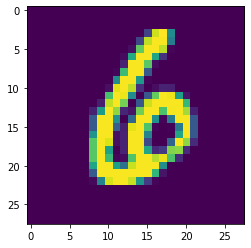

In [6]:
from matplotlib import pyplot as plt
plt.imshow(train_6[10], interpolation='nearest')
plt.show()

In [7]:
"""
merge 28x28 to 784 size feature vector
"""
def prepro(data):
    arr_5 = []
    for i in data:
        arr_6=[]
        for j in range(len(i)):
            arr_6.extend(i[:,j])
        arr_5.append(arr_6)
    return arr_5

In [8]:
train5 = np.array(prepro(train_5))
train6 = np.array(prepro(train_6))
test5 = np.array(prepro(test_5))
test6 = np.array(prepro(test_6))

In [9]:
"""add the label, here label=0 -> digit 5 and label=1 -> digit 6"""
train5=np.c_[train5,np.zeros(train5.shape[0])]
train6=np.c_[train6,np.ones(train6.shape[0])]
test5=np.c_[test5,np.zeros(test5.shape[0])]
test6=np.c_[test6,np.ones(test6.shape[0])]

train5.shape

(5421, 785)

In [19]:
train = np.concatenate((train5,train6),axis=0)
test = np.concatenate((test5,test6),axis=0)

In [20]:
train[:,:-1].shape

(11339, 784)

In [21]:
"""normalize the data by subtracting the mean and divide by variance, if variance is 0 then just subtract mean"""
def normalize(mat):
    mean = mat.mean(0)
    std = mat.std(0)
    for i in range(mat.shape[1]):
        if(std[i]!=0):
            mat[:,i]=(mat[:,i] - mean[i])/std[i]
        else:
            mat[:,i]=(mat[:,i] - mean[i])
    return mat

In [22]:
x = normalize(train[:,:-1])
x_test = normalize(test[:,:-1])

In [23]:
#x[0]

In [24]:
x_test.shape

(1850, 784)

In [25]:
"""calculate the covariance matrix for the feature vectors, and then calculate corresponding eigen values and eigen vectors"""
def PCA(x):
    cov_x = np.cov(x.T)
    eig = LA.eig(cov_x)
    return eig

In [26]:
eig = PCA(x)

In [27]:
eig[0].shape

(784,)

In [28]:
eig_vals = eig[0]
eig_vecs = eig[1]

In [29]:
"""sort the eigen vectors with respect to the order of eigen values"""
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)

In [30]:
print(eig[0][0],eig[1][0])

51.41078512078789 42.16026337982371


In [32]:
"""select the eigen vectors corresponding to the top 'd' dimensions eigen values, in our case top 2 eigen vectors"""
eig_vectors = []

for i in range(reduced_dimensions):
    eig_vectors.append(eig_pairs[i][1])
eig_vectors = np.asarray(eig_vectors)

In [33]:
#eig_vectors[0]

In [34]:
np.shape(eig_vectors)

(2, 784)

In [35]:
print(eig_pairs[1][0],eig_pairs[0][0])

NameError: name 'eig_pairs' is not defined

In [26]:
"""Project the data onto the eigen vectors(dot product between data and eigen vectors)"""
p_comp = np.dot(x,eig_vectors.T)
p_comp_test = np.dot(x_test,eig_vectors.T)

In [27]:
print(np.shape(p_comp),np.shape(p_comp_test))


(11339, 2) (1850, 2)


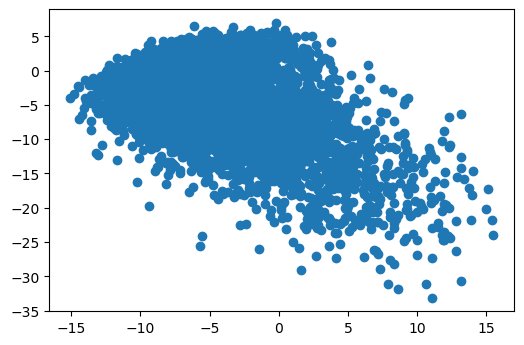

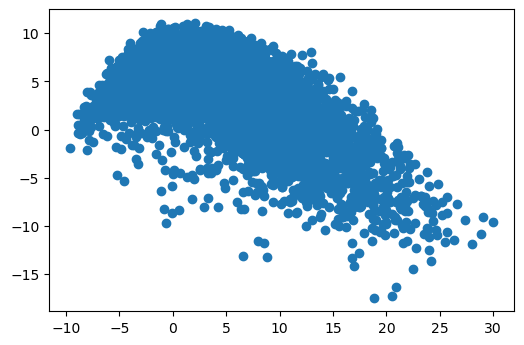

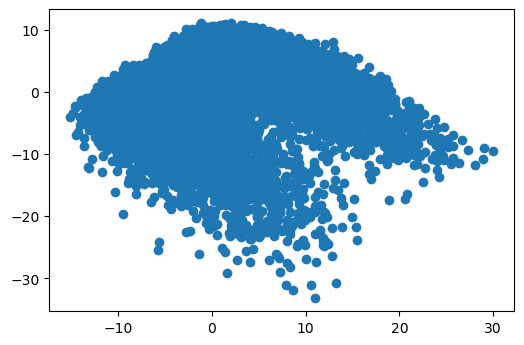

In [48]:
"""Scatter plot of the projected training data with respect to principal components for digits 5 and 6.
as we observe the data is concentrated onto narrow range of (-10,0) for both pc1 and pc2 for digit 5 and between (0,10) for PC1
and (-5,10) for PC2 for digit 6"""
scatter = np.array(p_comp)
plt.figure(dpi=120)
plt.scatter(scatter[:5421,0],scatter[:5421,1])
plt.figure(dpi=120)
plt.scatter(scatter[5421:,0],scatter[5421:,1])
plt.figure(dpi=120)
plt.scatter(scatter[:,0],scatter[:,1])

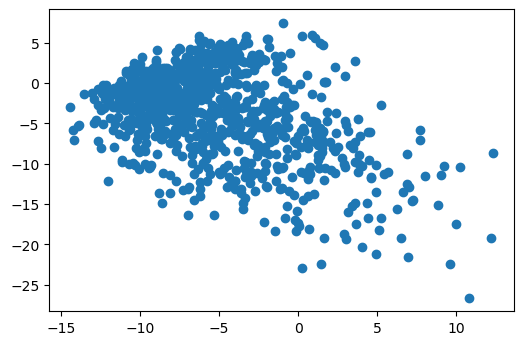

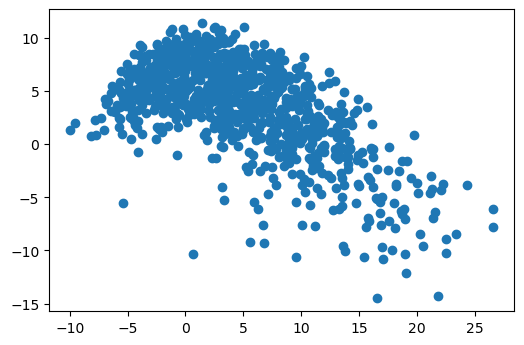

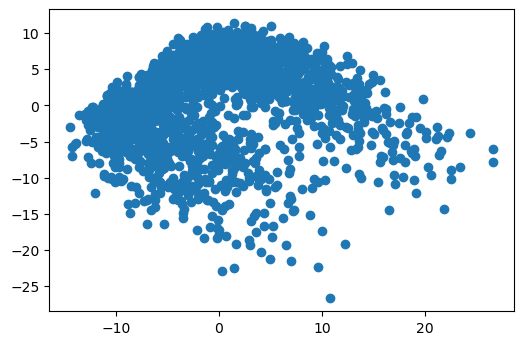

In [49]:
"""Scatter plot of the projected test data with respect to principal components for digits 5 and 6.
as we observe the data is concentrated onto narrow range of (-5,5) for pc1 and (-12,-2) for pc2 for digit 5 and
between (0,10) for PC1 and (-4,5) for PC2 for digit 6"""
scatter = np.array(p_comp_test)
plt.figure(dpi=120)
plt.scatter(scatter[:892,0],scatter[:892,1])
plt.figure(dpi=120)
plt.scatter(scatter[892:,0],scatter[892:,1])
plt.figure(dpi=120)
plt.scatter(scatter[:,0],scatter[:,1])

In [50]:
"""created a dataframe with respect to train and test data adding the label column. label=0 -> digit 5 and label=1 -> digit 6"""
train_df = pd.DataFrame(p_comp)
train_df['label'] = train[:,-1]
test_df = pd.DataFrame(p_comp_test)
test_df['label'] = test[:,-1]

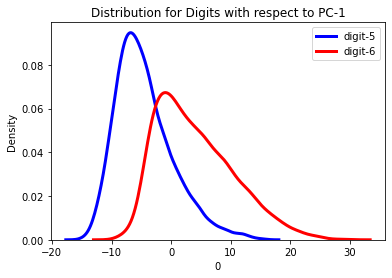

In [51]:
"""The below 4 plots are for the distribution of components PC1 and PC2 with respect train and test. essentially they show
the density of value of Principal component for digit 5 and 6 for train and test. This plot would kind of give us a good idea
as to how the values of features/PC are distributed with respect to the class"""

PC1_5 = train_df.loc[train_df.label == 0][0]
PC1_6 = train_df.loc[train_df.label == 1][0]

sns.distplot(PC1_5,hist = False,kde = True,kde_kws = {'linewidth': 3}, color='blue',label = 'digit-5')
sns.distplot(PC1_6,hist = False,kde = True,kde_kws = {'linewidth': 3}, color='red',label = 'digit-6')
plt.gca().set(title='Distribution for Digits with respect to PC-1')
plt.legend()

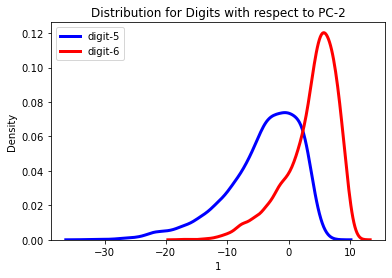

In [52]:
PC2_5 = train_df.loc[train_df.label == 0][1]
PC2_6 = train_df.loc[train_df.label == 1][1]

sns.distplot(PC2_5,hist = False,kde = True,kde_kws = {'linewidth': 3}, color='blue',label = 'digit-5')
sns.distplot(PC2_6,hist = False,kde = True,kde_kws = {'linewidth': 3}, color='red',label = 'digit-6')
plt.gca().set(title='Distribution for Digits with respect to PC-2')
plt.legend()

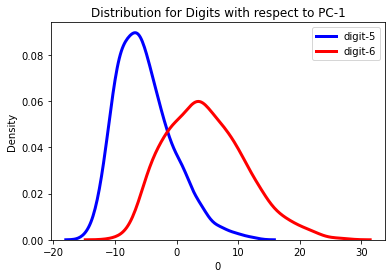

In [53]:
PC1_5 = test_df.loc[test_df.label == 0][0]
PC1_6 = test_df.loc[test_df.label == 1][0]

sns.distplot(PC1_5,hist = False,kde = True,kde_kws = {'linewidth': 3}, color='blue',label = 'digit-5')
sns.distplot(PC1_6,hist = False,kde = True,kde_kws = {'linewidth': 3}, color='red',label = 'digit-6')
plt.gca().set(title='Distribution for Digits with respect to PC-1')
plt.legend()

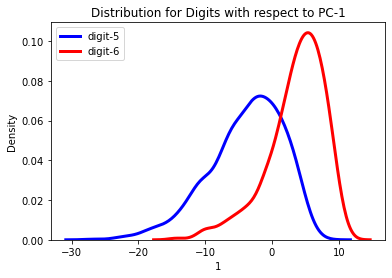

In [54]:
PC2_5 = test_df.loc[test_df.label == 0][1]
PC2_6 = test_df.loc[test_df.label == 1][1]

sns.distplot(PC2_5,hist = False,kde = True,kde_kws = {'linewidth': 3}, color='blue',label = 'digit-5')
sns.distplot(PC2_6,hist = False,kde = True,kde_kws = {'linewidth': 3}, color='red',label = 'digit-6')
plt.gca().set(title='Distribution for Digits with respect to PC-1')
plt.legend()

In [35]:
"""We know that the gaussian parameter estimation over a given dataset would result in mean of distribution to be sample mean
and variance to be variance of sample which are computed below with respect to given classes (digits 5 and 6)"""
mean_of_digit_5 = []
for i in range(reduced_dimensions):
    mean_of_digit_5.append(np.mean(train_df[i][train_df['label'] == 0]))
mean_of_digit_5 = np.asarray(mean_of_digit_5)

In [36]:
cov_of_digit_5 = np.cov(train_df.loc[:,[0,1]][train_df['label'] == 0].T)

In [37]:
print(mean_of_digit_5,'\n',cov_of_digit_5)

[-4.4531976 +0.j -4.06950581+0.j] 
 [[ 23.39752387+0.j -15.13656603+0.j]
 [-15.13656603+0.j  36.44251424+0.j]]


In [38]:
mean_of_digit_6 = []
for i in range(reduced_dimensions):
    mean_of_digit_6.append(np.mean(train_df[i][train_df['label'] == 1]))
mean_of_digit_6 = np.asarray(mean_of_digit_6)

In [39]:

cov_of_digit_6 = np.cov(train_df.loc[:,[0,1]][train_df['label'] == 1].T)


In [40]:
print(mean_of_digit_6,'\n',cov_of_digit_6)

[4.07921328+0.j 3.72774434+0.j] 
 [[ 42.26834766+0.j -17.94685568+0.j]
 [-17.94685568+0.j  18.33380651+0.j]]


In [41]:
"""Here we define the function for our multivariate normal distribution with calculated mean and covariance"""
def multivariate_normal_pdf(mean, covariance_matrix, X):

    D = len(mean)  # Number of dimensions
    det_of_cov = np.linalg.det(covariance_matrix)
    inverse_of_cov = np.linalg.inv(covariance_matrix)
    exponent = -0.5 * np.dot(np.dot((X-mean).T, inv_cov), X-mean)
    probability_density = (1 / (np.sqrt((2 * np.pi) ** D * det_cov)) * np.exp(exponent))
    return probability_density

In [42]:
"""Here we define the classifier which essentially calculates the class conditionals. Here the data points are substituted in
the multivariate normal pdf we calculated with mean and variance as sample mean and variance for each class. This value is 
calculated for each class and multiplied with the prior. As per our knowledge of bayesian decision theory, we pick the class 
having the greater class conditional out of the given distribution"""
def classifier(data, prior_P_5, prior_P_6):
        
    cl_cond_1 = multivariate_normal_pdf(mean_of_digit_5,cov_of_digit_5,data) * prior_P_5
    cl_cond_2 = multivariate_normal_pdf(mean_of_digit_6,cov_of_digit_6,data) * prior_P_6
    
    if cl_cond_1 >= cl_cond_2:
        return 0
    return 1

In [43]:
pred_train = [classifier(i, prior_P_5, prior_P_6) for i in p_comp]
pred_test = [classifier(i, prior_P_5, prior_P_6) for i in p_comp_test]

In [44]:
train_df['pred_train'] = pred_train
test_df['pred_test'] = pred_test

In [45]:
"""We have obtained a training accuracy of 94.277 and testing accuracy of 94.11"""
training_acc = np.mean(train_df['label'] == train_df['pred_train'])
print(training_acc)

0.9427639121615663


In [46]:
testing_acc = np.mean(test_df['label'] == test_df['pred_test'])
print(testing_acc)

0.9394594594594594
